In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf
from datetime import datetime

In [ ]:
# xgboost
import xgboost
print("xgboost", xgboost.__version__)

xgboost 2.0.0


In [ ]:
energy_hourly = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [ ]:
energy_hourly.sort_index(inplace=True)

In [ ]:
energy_hourly.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [ ]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), data[data.index >  split_date].copy()

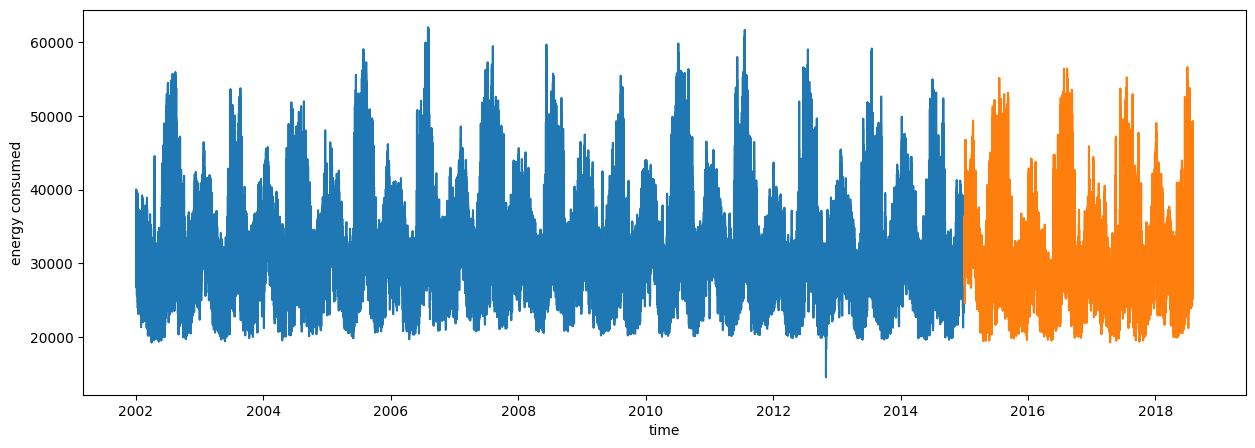

In [ ]:
train, test = split_data(energy_hourly, '01-Jan-2015')

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [ ]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [ ]:
X_train, y_train = create_features(train), train['PJME_MW']
X_test, y_test   = create_features(test), test['PJME_MW']

X_train.shape, y_train.shape

<ipython-input-10-30fc047ebcc6>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-10-30fc047ebcc6>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


((113927, 8), (113927,))

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

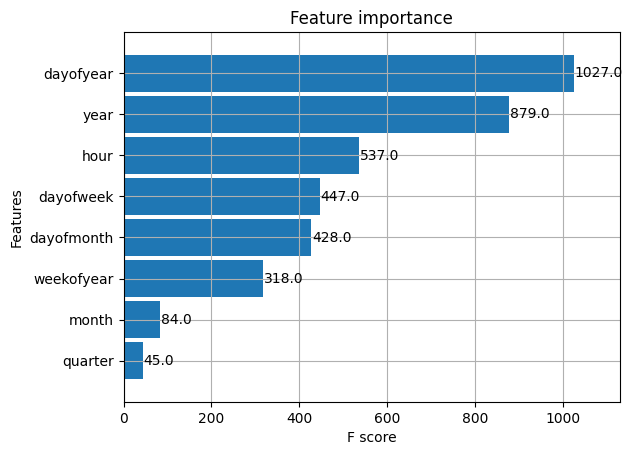

In [ ]:
xgb.plot_importance(reg, height=0.9)

In [ ]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(energy_hourly.index,energy_hourly, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

In [ ]:
print(X_test)

                     hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2015-01-01 01:00:00     1          3        1      1  2015          1   
2015-01-01 02:00:00     2          3        1      1  2015          1   
2015-01-01 03:00:00     3          3        1      1  2015          1   
2015-01-01 04:00:00     4          3        1      1  2015          1   
2015-01-01 05:00:00     5          3        1      1  2015          1   
...                   ...        ...      ...    ...   ...        ...   
2018-08-02 20:00:00    20          3        3      8  2018        214   
2018-08-02 21:00:00    21          3        3      8  2018        214   
2018-08-02 22:00:00    22          3        3      8  2018        214   
2018-08-02 23:00:00    23          3        3      8  2018        214   
2018-08-03 00:00:00     0          4        3      8  2018        215   

                     dayofmonth  weekofyear  
Date

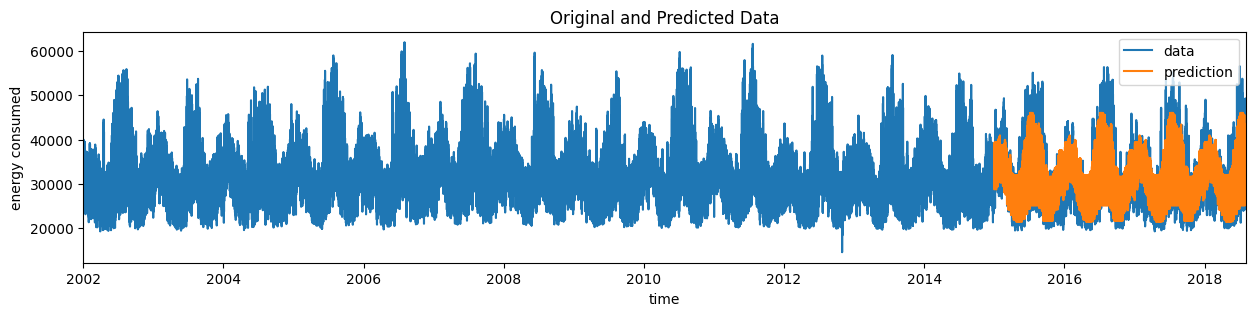

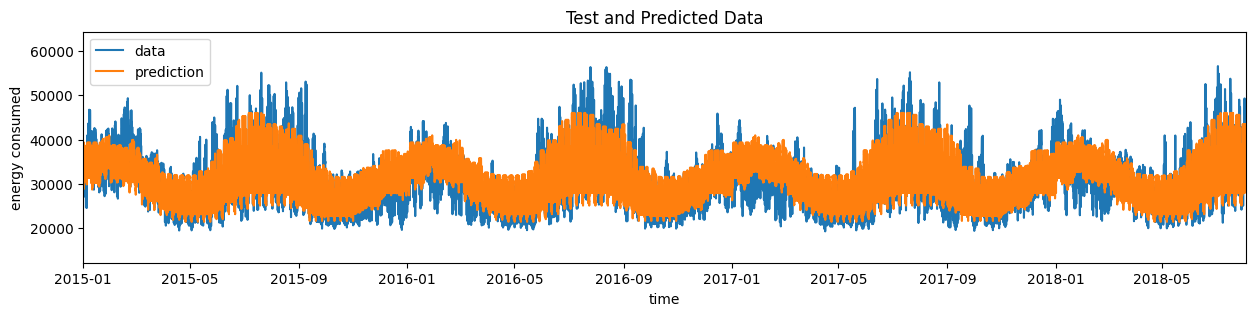

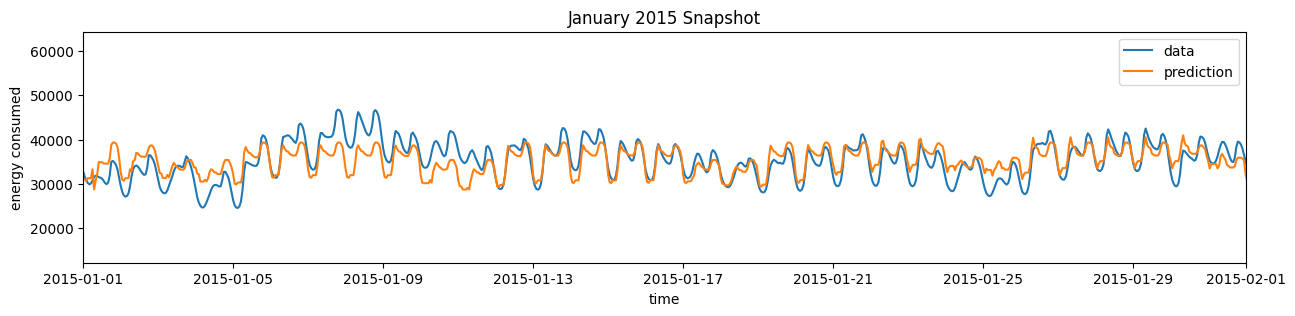

In [ ]:
X_test_pred = reg.predict(X_test)

plot_performance(energy_hourly, energy_hourly.index[0].date(), energy_hourly.index[-1].date(),
                 'Original and Predicted Data')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')

plot_performance(y_test, datetime.strptime('01-01-2015','%m-%d-%Y').date(), datetime.strptime('02-01-2015','%m-%d-%Y').date(), 'January 2015 Snapshot')

plt.legend()

plt.show()

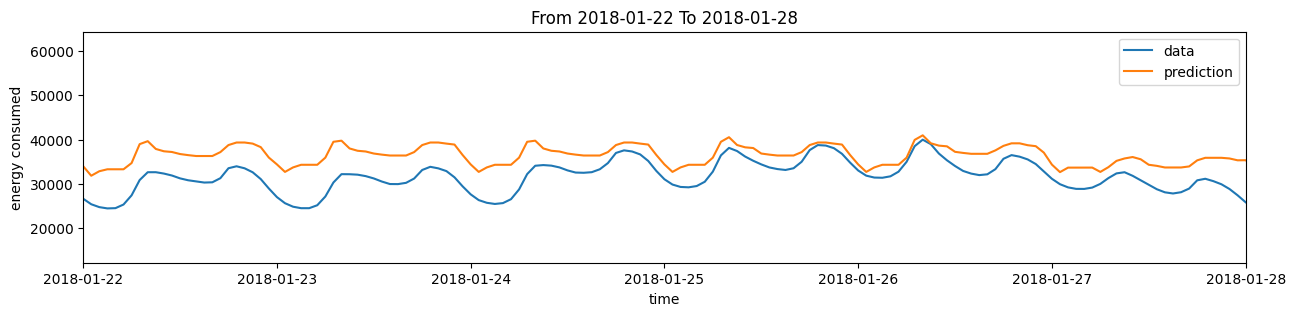

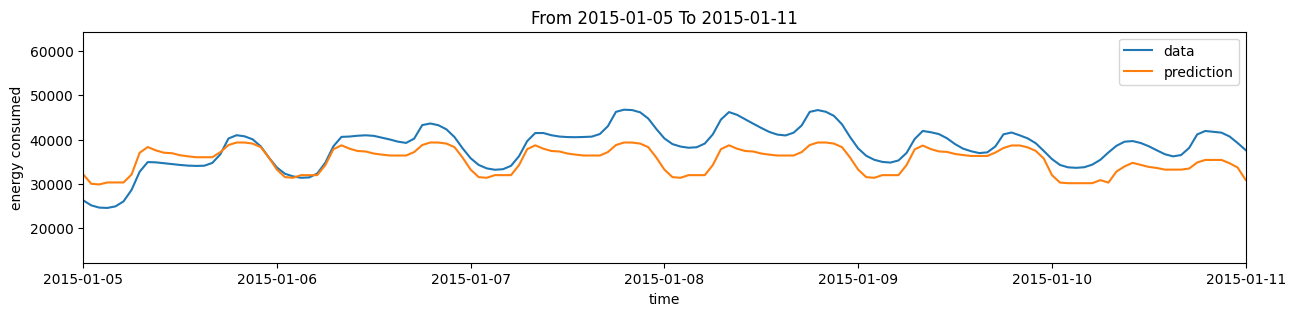

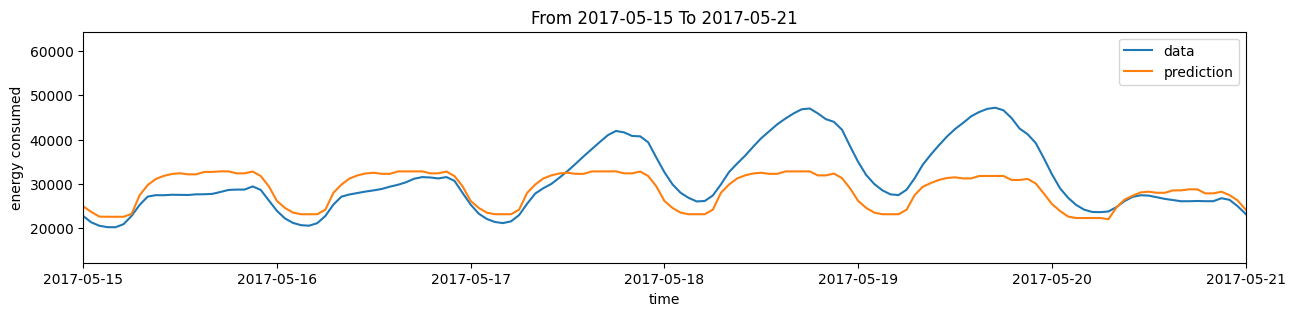

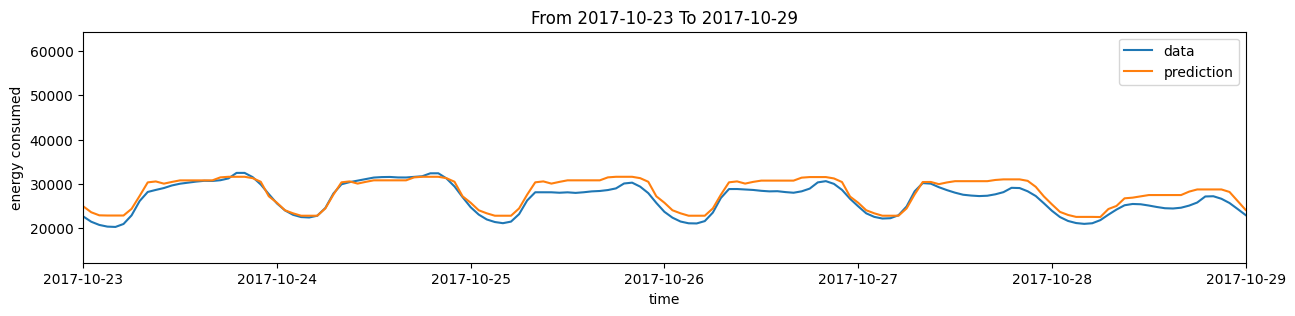

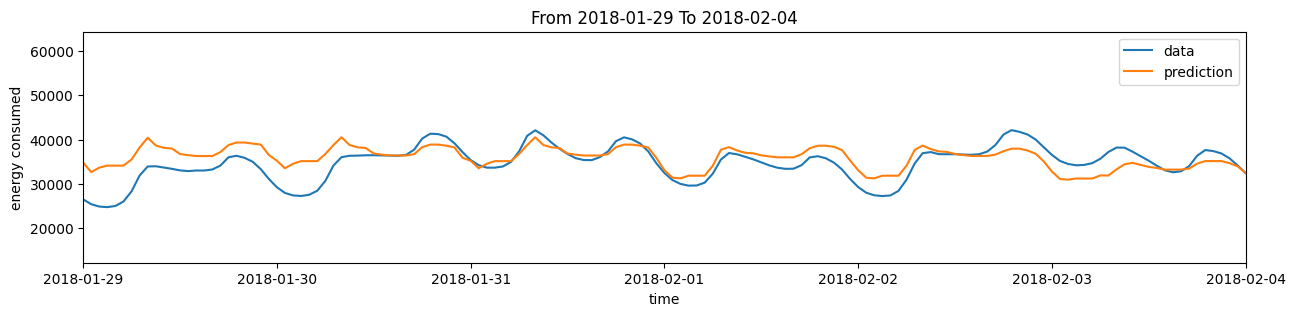

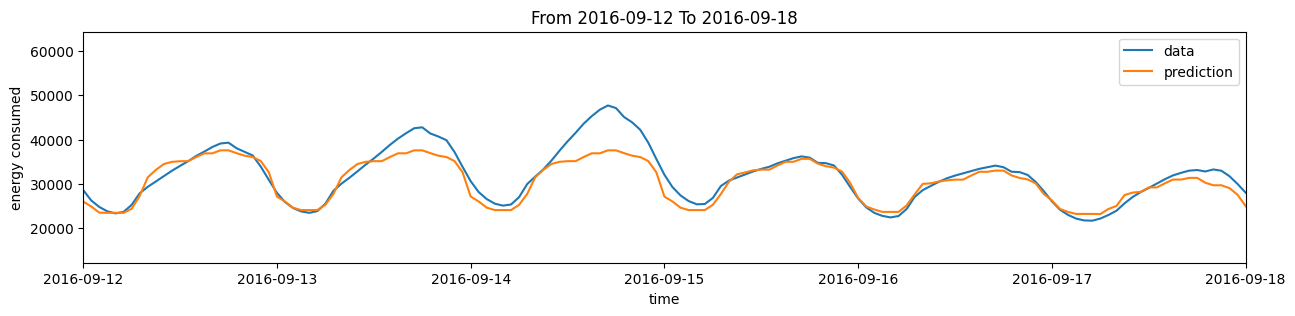

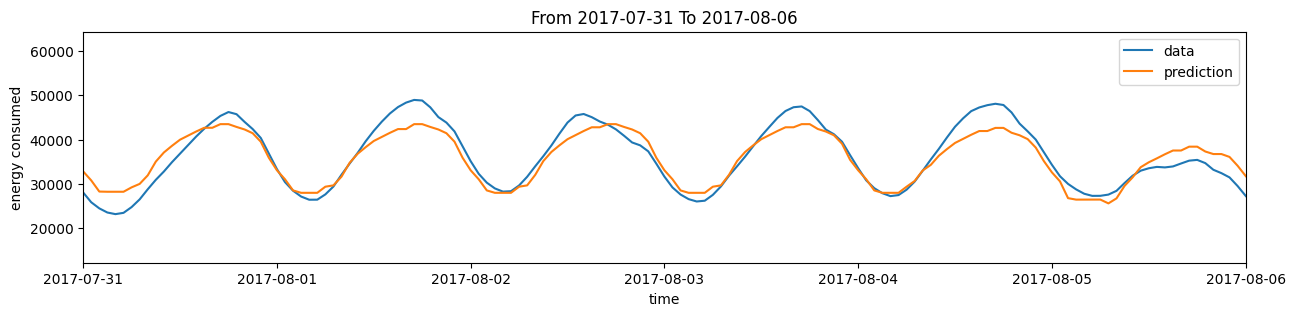

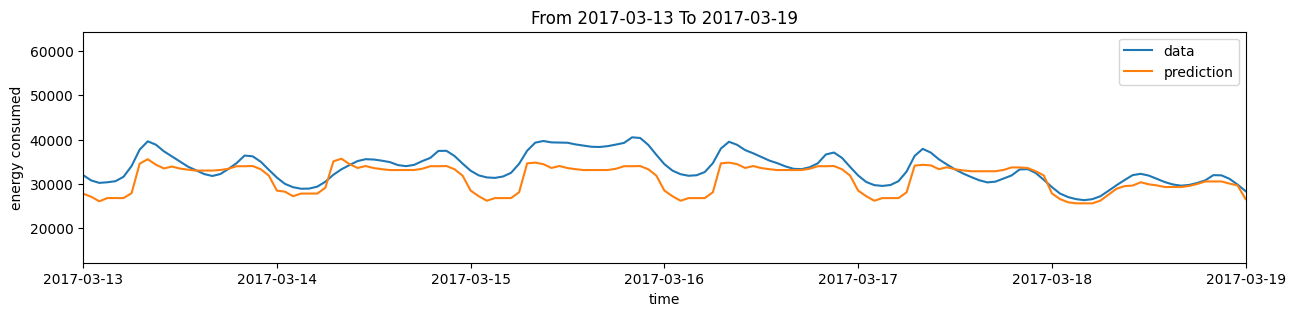

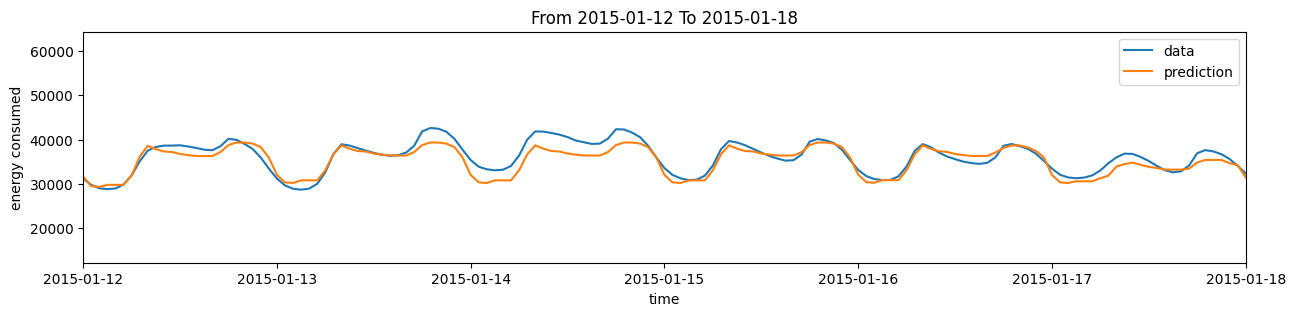

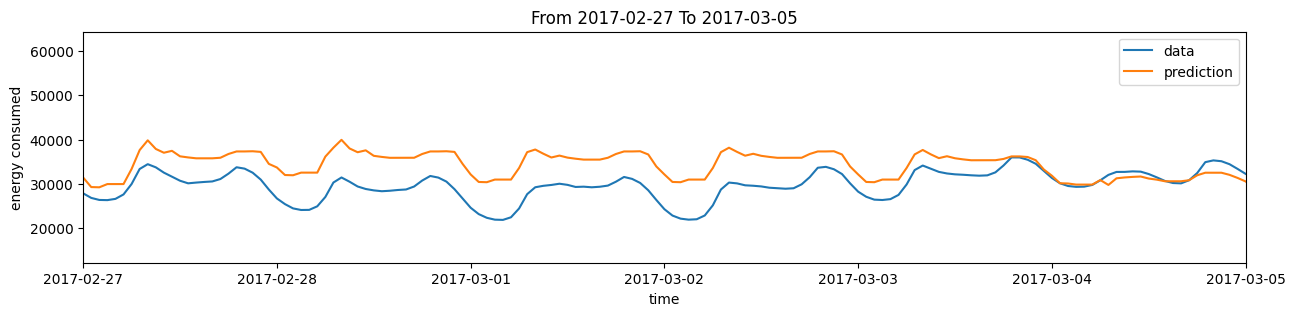

In [ ]:
random_weeks = X_test[['year', 'weekofyear']].sample(10)
for week in random_weeks.iterrows():
    index = (X_test.year == week[1].year) & \
            (X_test.weekofyear == week[1].weekofyear)
    data = y_test[index]
    plot_performance(data, data.index[0].date(), data.index[-1].date())